Repeat of the experiment done in 

**Learning long-term dependencies with gradient descent is difficult**

https://dl.acm.org/citation.cfm?id=2328340

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

In [2]:
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [3]:
seq_len = 5
N = 10000
batch_size = 100

xs = np.zeros((N, seq_len))
ys = np.zeros(N)

# construct input data
positive_indexes = np.arange(N // 2)
negative_indexes = np.arange(N // 2, N)

xs[positive_indexes, 0] = 10
ys[positive_indexes] = 1

xs[negative_indexes, 0] = -10
ys[negative_indexes] = 0

noise = np.random.normal(loc=0, scale=0.1, size=(N, seq_len))

train_xs = (xs + noise).reshape(N, seq_len, 1)
train_ys = ys

inputs = Input(shape=(None, 1), name='input')
rnn = LSTM(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
# dense = Dense(2, activation='softmax', name='output')
# dense = Dense(1, activation='sigmoid', name='output')
dense = Dense(1, activation='relu', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
adam = Adam(lr=1e-5)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=10,
                 validation_split=0.2, 
                 verbose=0)

In [4]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

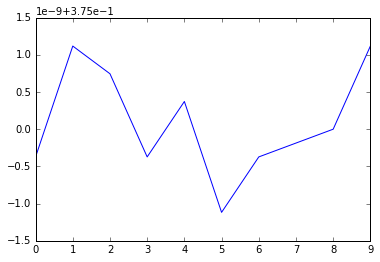

In [5]:
plt.plot(hist.history['acc'])

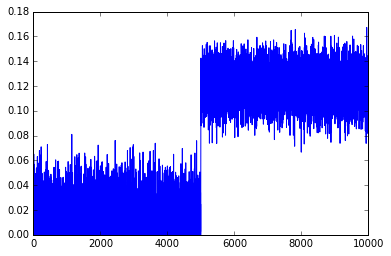

In [6]:
# the positive and negative only vary by a small difference considering output from sigmoid
plt.plot(model.predict(train_xs))

ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Since the input at each time step is only 1 dimension, so I used $w$ (scalar) instead of $W$ (matrix).

<img src="./lstm.png" width=600/>

Calculate gates:

\begin{align*}
f_t &= \sigma(w_f[h_{t-1}, x_t]) + b_f \\
i_t &= \sigma(w_i[h_{t-1}, x_t]) + b_i \\
\tilde{C}_t &= \tanh(w_C[h_{t-1}, x_t]) + b_C \\
o_t &= \sigma(w_o[h_{t-1}, x_t]) + b_o
\end{align*}

Update $C_t$ and $h_t$,
\begin{align*}
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align*}

In [7]:
rnn.get_weights()

[array([[-1.0279149 , -0.74228495, -0.05060584, -0.2164469 ]],
       dtype=float32),
 array([[-0.9186729 , -0.08337967,  0.3383234 , -0.26363912]],
       dtype=float32),
 array([ 0.01147038,  1.0116643 , -0.00872571,  0.01158455], dtype=float32)]

In [8]:
kernel = np.array(rnn.get_weights()[:2])[:,0,:]
kernel

array([[-1.0279149 , -0.74228495, -0.05060584, -0.2164469 ],
       [-0.9186729 , -0.08337967,  0.3383234 , -0.26363912]],
      dtype=float32)

In [9]:
w_i, w_f, w_c, w_o = kernel.T

In [10]:
b_i, b_f, b_c, b_o = rnn.get_weights()[-1]

In [11]:
# w_i, w_f = w_f, w_i
# b_i, b_f = b_f, b_i

In [12]:
print(w_i, b_i)
print(w_f, b_f)
print(w_c, b_c)
print(w_o, b_o)

[-1.0279149 -0.9186729] 0.011470384
[-0.74228495 -0.08337967] 1.0116643
[-0.05060584  0.3383234 ] -0.008725711
[-0.2164469  -0.26363912] 0.011584546


In [30]:
single_x = train_xs[-1]
single_x

array([[-10.07662195],
       [  0.08844112],
       [  0.02992779],
       [  0.01275387],
       [ -0.09939528]])

In [31]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [43]:
h_prev = 0
C_prev = 0

hist = []
for t in range(single_x.shape[0]):
    cat_x = [h_prev, single_x[t][0]]
#     cat_x = [single_x[t][0], h_prev]
    f_t = sigmoid(np.dot(w_f, cat_x) + b_f)
    i_t = sigmoid(np.dot(w_i, cat_x) + b_i)
    B_t = np.tanh(np.dot(w_c, cat_x) + b_c) # use B to mean \tilde{C}
    o_t = sigmoid(np.dot(w_o, cat_x) + b_o)

    C_t = f_t * C_prev + i_t * B_t
    h_t = o_t * np.tanh(C_t)

    hist.append([f_t, i_t, B_t, o_t, C_t, h_t])

    h_prev = h_t
    C_prev = C_t

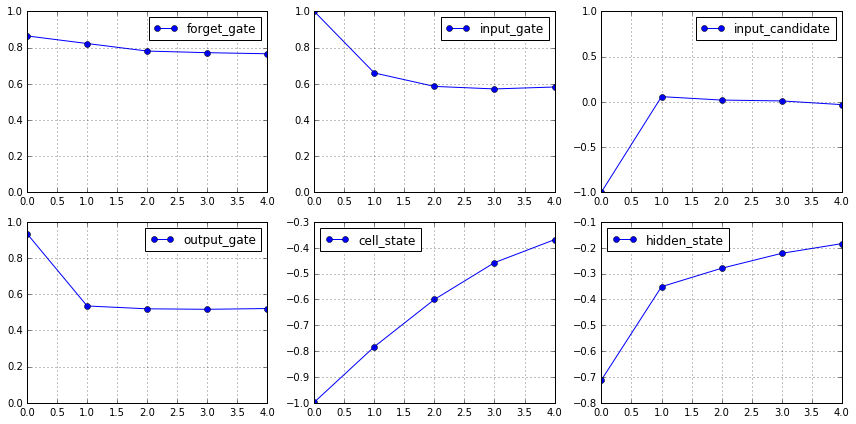

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), 
#                          sharex=True, sharey=True
                        )
axes = axes.ravel()

for k, i in enumerate([
    'forget_gate', 'input_gate', 'input_candidate', 'output_gate', 
    'cell_state', 'hidden_state'
]):
    ax = axes[k]
    ax.plot(np.array(hist)[:,k], 'o-', label=i)
    ax.legend(loc='best')
    ax.grid()
    
    if k in [0, 1, 3]:
        ax.set_ylim(0, 1)
    if k == 2:
        ax.set_ylim(-1, 1)

plt.tight_layout()

So seems that `input_candidate` are completely ignored

In [45]:
dense.get_weights()

[array([[-0.6719197]], dtype=float32), array([0.00862497], dtype=float32)]

In [46]:
den_in = hist[-1][-1] # dense input

In [47]:
den_in

-0.18381250751969055

In [48]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[-0.6719197] [0.00862497]


In [49]:
np.max([den_in * d_w0 + d_b0, 0])
# sigmoid(den_in * d_w0 + d_b0)

array([0.13213222], dtype=float32)

In [50]:
# sigmoid(den_in * d_w0 + d_b0)

In [51]:
model.predict(np.array([single_x]))

array([[0.]], dtype=float32)

Now it seems the calculation is just wrong

In [17]:
# # for softmax Dense layer
# [d_w0, d_w1] = dense.get_weights()[0][0]
# [d_b0, d_b1] = dense.get_weights()[1]

# logit0 = den_in * d_w0 + d_b0

# logit1 = den_in * d_w1 + d_b1

# np.exp(-logit0) / (np.exp(-logit0) + np.exp(-logit1))

ValueError: not enough values to unpack (expected 2, got 1)

In [67]:
# ref https://github.com/keras-team/keras/blob/d035967a5d2795734c89a0a3c002f7eb5c34eff1/keras/layers/recurrent.py#L1941
# kernel_i = kernel[:, :units]
# kernel_f = kernel[:, units: units * 2]
# kernel_c = kernel[:, units * 2: units * 3]
# kernel_o = kernel[:, units * 3:]

In [3]:
N = 10000
num_epochs = 30
# sequence length options
lens = [2, 5, 8, 10, 15, 20, 25, 30] + np.arange(30, 210, 10).tolist()

res = {}
for (RNN_CELL, key) in zip([SimpleRNN, LSTM], ['srnn', 'lstm']):
    res[key] = {}
    print(key, end=': ')
    for seq_len in lens:
        print(seq_len, end=',')
        xs = np.zeros((N, seq_len))
        ys = np.zeros(N)

        # construct input data
        positive_indexes = np.arange(N // 2)
        negative_indexes = np.arange(N // 2, N)

        xs[positive_indexes, 0] = 1
        ys[positive_indexes] = 1

        xs[negative_indexes, 0] = -1
        ys[negative_indexes] = 0

        noise = np.random.normal(loc=0, scale=0.1, size=(N, seq_len))

        train_xs = (xs + noise).reshape(N, seq_len, 1)
        train_ys = ys

        # train for multiple epochs
        hists = []
        for i in range(num_epochs):
            inputs = Input(shape=(None, 1), name='input')
            # rnn = SimpleRNN(1, input_shape=(None, 1), name='rnn')(inputs)
            rnn = RNN_CELL(1, input_shape=(None, 1), name='rnn')(inputs)
            out = Dense(2, activation='softmax', name='output')(rnn)
            model = Model(inputs, out)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            hist = model.fit(train_xs, train_ys, epochs=5, shuffle=True, validation_split=0.2, batch_size=16, verbose=0)
            hists.append(hist.history['val_acc'][-1])
        res[key][seq_len] = hists
    print()

srnn: 2,5,8,10,15,20,25,30,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,
lstm: 2,5,8,10,15,20,25,30,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,


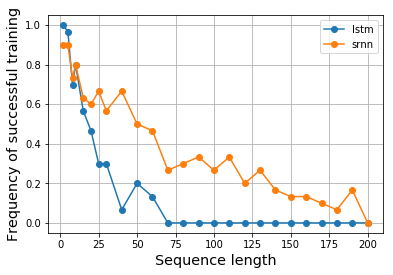

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pd.DataFrame.from_dict(res['lstm']).mean(), 'o-', label='lstm')
ax.plot(pd.DataFrame.from_dict(res['srnn']).mean(), 'o-', label='srnn')
ax.set_xlabel('Sequence length')
ax.set_ylabel('Frequency of successful training')
ax.legend()
ax.grid()